## Edelweiss use case: storing the in-house generated raw data (version 2.0)

**Goal:** start with the laboratory generated excel file, which contains metadata and measurements of the assay plate. The script creates a csv file, which is ready to be uploaded to Edelweiss.

**Description:** the excel file contains:
- "Metadata" sheet with info regarding the study
- "Test items" sheet with info on compound properies (SMILES, CAS, etc.)
- "Plate design" sheet with three assay plate layouts (one for description of the well content,one for the compound name and one for the concentration)
- "Results raw data #" sheet(s) with the number in the name corresponding to the number of the experimental run

**Note:** The final csv file has the same name as the source excel file (except for the extension, of course).

### Set the filename of the original dataset

In [1]:
filename = "HepG2 MTT 72h Thioacetamide 20190607 - upload test.xlsx"

### Import libraries

In [2]:
import pandas as pd
import re

### Check that pandas version is 0.23.4

In [3]:
if pd.__version__  != '0.23.4':
    !pip install pandas==0.23.4
    import pandas as pd
    print(pd.__version__)

In [4]:
print('Pandas version:', pd.__version__)

Pandas version: 0.23.4


### Read the raw excel file & extract assay plate design, concentrations, responses

In [5]:
df = pd.read_excel(filename, sheet_name=None, dtype=object, index_col=None)

In [6]:
def addNamesToThePlate(plate):
    plate.index.name = "Row"
    plate.columns.name = "Column"
    return plate

In [7]:
plateDesign = addNamesToThePlate( df['Plate design'].iloc[0:8, 0:12])
plateTestItems = addNamesToThePlate( df['Plate design'].iloc[10:18, 0:12])
plateConcentrations = addNamesToThePlate(df['Plate design'].iloc[20:28, 0:12])

### Collect plates with responses for different experiments

Extract the assay plates with responses. There may be several such assay plates within a given excel file. However, they should differ in at least the experiment number (and data/time). The experiment number is extracted from the name of the sheet. Date and time are extracted from the heading in the sheet. All this data is collected in a dictionary `plateResponses`. For each experiment number a nested dictionary is created with the "plate", "date" and "time" keys.

In [8]:
def reorganizePlate(plate):
    plate.set_index(plate.iloc[:,0], inplace=True)
    plate.columns = plate.iloc[0, :].fillna(0).astype(int)
    plate.index.name = "Row"
    plate.columns.name = "Column"
    plate = plate.iloc[1:,1:]
    return plate

In [9]:
plateResponses = {}  # start a dictionary that will collect assay plates for different experiment numbers

for key in df.keys():
    print(key)
    try:
        experimentNumber = key.split('#')[1]       
    except:
        experimentNumber = None
        
    # if experiment number is not None, then it is a valid assay data sheet and we should proceed with extracting additional info (date, time, responses)
    if experimentNumber is not None:
        topLine = df[key].columns[3].split()
        botLine = df[key].iloc[0, 3].split()
        
        # remove the first element in each line
        topLine = topLine[1:]
        botLine = botLine[1:]
        
        # remove the elements of top line from the bottom line
        for item in topLine:
            botLine.remove(item)
            
        # recognize date as XXXX.XX.XX and time as XX:XX:XX and remove them from list (so only compound name remains)
        rDate = re.compile("(\d+\.\d+\.\d+)")
        rTime = re.compile("(\d+\:\d+\:\d+)")
        date = list(filter(rDate.match, botLine))[0]
        time = list(filter(rTime.match, botLine))[0]
        botLine.remove(date)
        botLine.remove(time)
        
        # extract compound if the list is not empty
        if botLine:
            compound = " ".join(botLine)
            print(compound)
        else:
            print('No compound defined')        
        
        plateResponses[experimentNumber] = {}
        plateResponses[experimentNumber]['plate'] = reorganizePlate(df[key].iloc[7:16, 4:17])
        plateResponses[experimentNumber]['date'] = date
        plateResponses[experimentNumber]['time'] = time

Metadata
Test items
Plate design
Results raw data #1
Thioacetamide


### Collect properties of test items (sort of meta data)

Collect test items properties (from a "Test items" sheet) in a dictionary `dictTestItems` that will be used later to map the specific test item to its SMILES, CAS, etc. The primary key is a test item (compound name), which then points to the nested dictionary with compounds properties.

But first, we need to create a "temporary" dictionary `d` (which is not useful for the mapping), which will subsequently be transformed to an actually useful dictionary `dictTestItems`.

In [10]:
d = df['Test items'].set_index('Test item').to_dict(orient='index')

In [11]:
dictTestItems = {}

# loop through primary keys (test items)
for key, value in d.items():
    # loop through secondary keys (compound properties)
    for key2, value2 in value.items():
        # if the key already exists, append the property to it. Otherwise, create a nested dictionary and append the property to it.
        if key2 in dictTestItems:
            dictTestItems[key2][key] = value2
        else:
            dictTestItems[key2] = {}
            dictTestItems[key2][key] = value2

### Build final dataframe

Initiate dataframe `data` that will store assay plate descriptions and measurements in a more convenient form (each row of dataframe `data` corresponds to a single plate well). Extract information on compound, replicate and concentration from the assay plate descriptions.

First the dataframe `subdata` is created for each experiment number (assay plate), and then these are concatenated into a dataframe `data`.

In [12]:
data = pd.DataFrame()

for key in plateResponses:
    subdata = pd.DataFrame()
    
    subdata['Well'] = plateDesign.stack()
    subdata['Test item'] = plateTestItems.stack()

    subdata['Concentration'] = plateConcentrations.stack().str.split().str[0]
    subdata['Concentration unit'] = plateConcentrations.stack().str.split().str[1]  # add a concentration unit column!   

    subdata['Response'] = plateResponses[key]['plate'].stack()
    
    # constant field for a given assay plate
    subdata['Date'] = plateResponses[key]['date']
    subdata['Time'] = plateResponses[key]['time']
    subdata['Experiment number'] = int(key)
    
    # map compound properties to the compound name ("test item" column)
    for key in dictTestItems:
        subdata[key] = subdata['Test item'].map(dictTestItems[key])
        
    data = pd.concat([data, subdata], axis=0)

data = data.reset_index()

Collect the assay metadata in a series `meta`.

In [13]:
meta = df['Metadata'].transpose()
meta.columns = meta.loc["Column Name"]
meta = meta.loc["Value", :]

Some column names (e.g. Time unit) are repeated. These should be treated such that they become unique.

In [14]:
d = pd.DataFrame(meta).transpose()
for i in data.index:
    d = d.append(meta, ignore_index=True)
d = d[:-1]
d.index = data.index

In [15]:
#for index, value in meta.items():
#    data[index] = value

data = pd.concat([data, d], axis=1)

In [16]:
fileCSV = filename[:-5] + ".csv"
data.to_csv(fileCSV, index=False)

### Upload to EdelweissData

In [17]:
def uploadCSVandSchema(base, fileName, schemaName, collectionName, datasetName, position):
    import requests
    import json
        
    # Create collection
    payload = {
      "name": collectionName
    }
    
    url = base + '/collections'
    r = requests.post(url, data=json.dumps(payload))
    
    if r.status_code == 200:
        print('Collection created')
    else:
        print('Creating collection failed')
        return ""
        
    collectionId = r.json()['id']

    
    # Create dataset
    payload = {
      "datasetCollectionId": collectionId,
      "name": datasetName,
      "position": position
    }
    
    url = base + '/datasets/in-progress'
    r = requests.post(url, data=json.dumps(payload))

    if r.status_code == 200:
        print('Dataset created')
    else:
        print('Creating dataset failed')
        return ""
    
    datasetId = r.json()['id']


    # Upload dataset and schema
    url = base + '/datasets/in-progress/' + datasetId + '/upload-data-and-schema'

    files = {
        'data': open(fileName, 'rb'),
        'schema': open(schemaName, 'rb')
    }
    
    r = requests.post(url=url, files=files)
    
    if r.status_code == 200:
        print('Dataset uploaded')
    else:
        print('Uploading dataset failed')
        return ""
    
    
    # Publish dataset
    url = base + '/datasets/in-progress/' + datasetId + '/publish'

    r = requests.post(url=url)
    
    if r.status_code == 200:
        print('Successfully published dataset')
    else:
        print('Publishing failed')
        return ""
    return datasetId

In [18]:
def uploadCSV(base, fileName, collectionName, datasetName, position):
    import requests
    import json
        
    # Create collection
    payload = {
      "name": collectionName
    }
    
    url = base + '/collections'
    r = requests.post(url, data=json.dumps(payload))
    
    if r.status_code == 200:
        print('Collection created')
    else:
        print('Creating collection failed')
        return ""
        
    collectionId = r.json()['id']

    
    # Create dataset
    payload = {
      "datasetCollectionId": collectionId,
      "name": datasetName,
      "position": position
    }
    
    url = base + '/datasets/in-progress'
    r = requests.post(url, data=json.dumps(payload))

    if r.status_code == 200:
        print('Dataset created')
    else:
        print('Creating dataset failed')
        return ""
    
    datasetId = r.json()['id']


    # Upload dataset
    url = base + '/datasets/in-progress/' + datasetId + '/upload-data'

    files = {
        'data': open(fileName, 'rb')
    }
    
    r = requests.post(url=url, files=files)
    
    if r.status_code == 200:
        print('Dataset uploaded')
    else:
        print('Uploading dataset failed')
        return ""
    
    
    # Publish dataset
    url = base + '/datasets/in-progress/' + datasetId + '/publish'

    r = requests.post(url=url)
    
    if r.status_code == 200:
        print('Successfully published dataset')
    else:
        print('Publishing failed')
        return ""
    return datasetId

In [19]:
# Set the name of collection
collectionName = filename[:-5] + "_collection"
datasetName = filename[:-5] + "_dataset"
position= 0  # position in collection

registry = 'https://registry.edelweiss.douglasconnect.com'
#registry = 'https://registry.develop.edelweiss.douglasconnect.com'  

linkToEdelweiss = registry.replace('registry', 'dataexplorer')
fileSchema = "schema.json"

datasetId = uploadCSVandSchema(registry, fileCSV, fileSchema, collectionName, datasetName, position)
linkToEdelweiss = linkToEdelweiss + "?dataset=" + datasetId

from IPython.core.display import display, HTML
display(HTML("<a href=" + linkToEdelweiss + ">TAKE ME TO DATASET</a>"))

Collection created
Dataset created
Dataset uploaded
Successfully published dataset


### Visualize assay plates

In [20]:
try:
    import altair as alt
except ModuleNotFoundError:
    !pip install altair==2.3.0
    import altair as alt
    
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
chart = []

for en in data['Experiment number'].unique():
    # select a subset with a given experiment number
    g = data[data['Experiment number'] == en]
    g = g[['Row', 'Column', 'Response', 'Test item', 'Concentration', 'Concentration unit']].fillna(0.)
    
    
    chart.append(alt.Chart(
        g,
        title = "Experiment number: " + str(en)
    ).mark_rect().encode(
        y='Row:O',
        x='Column:O',
        color=alt.Color(
            'Response:Q',
            scale=alt.Scale(scheme='plasma')
        ),
        tooltip = [
            alt.Tooltip('Response:Q', title="response"),
            alt.Tooltip('Test item:N', title='compound'),
            alt.Tooltip('Concentration:Q', title='conc.'),
            alt.Tooltip('Concentration unit:N', title='unit')
        ]
    ).properties(width=300, height=200))


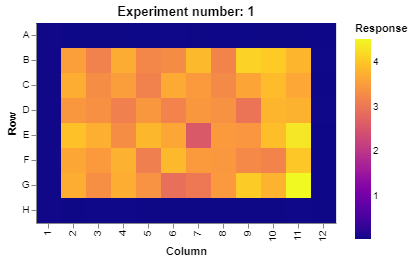

In [22]:
alt.vconcat(*chart)

In [23]:
alt.__version__

'3.2.0'